<a href="https://colab.research.google.com/github/pachterlab/monod_examples/blob/main/Monod_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Monod* on Colab

In the current notebook, we apply *Monod* to a set of small ($\approx$ 1000-cell) datasets.

# Inference pipeline

## Define aesthetics

In [1]:
import time
t1 = time.time()
#a e s t h e t i c s

fs = 16
nbin=40

#https://github.com/BlakeRMills/MetBrewer
Degas=("#591d06", "#96410e", "#e5a335", "#556219", "#418979", "#2b614e", "#053c29")
Demuth = ("#591c19", "#9b332b", "#b64f32", "#d39a2d", "#f7c267", "#b9b9b8", "#8b8b99", "#5d6174", "#41485f", "#262d42")


## Install prerequisites

In [2]:
!pip install -i https://pypi.org/simple/  monod  

Looking in indexes: https://pypi.org/simple/, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 4.4 MB/s 
     |████████████████████████████████| 99 kB 10.4 MB/s 
     |████████████████████████████████| 4.8 MB 33.1 MB/s 
     |████████████████████████████████| 189 kB 44.5 MB/s 
  Created wheel for loompy: filename=loompy-3.0.7-py3-none-any.whl size=52040 sha256=3cc04458dff3d3001eac359d4fc333fdb84f9f02db8a113e5c0601cb4937f5eb
  Stored in directory: /root/.cache/pip/wheels/48/36/9f/eb3377d4a7423b96105b6667d36c3faa49ee73b96d8cab80b3
  Created wheel for algopy: filename=algopy-0.5.7-py3-none-any.whl size=107608 sha256=7bf96239a0d73ad3ea7df274f0fa89be09fe9b08536adb5c5161530f2ef2b8ad
  Stored in directory: /root/.cache/pip/wheels/a8/fd/06/21dc6aba9f680fdbde386c06b1a8a1cf3d9a5f6bd96e31dcd4
Successfully built loompy algopy


## Import data

In [4]:
! git clone https://github.com/pachterlab/monod_examples.git

Cloning into 'monod_examples'...
remote: Enumerating objects: 345, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 345 (delta 4), reused 0 (delta 0), pack-reused 331
Receiving objects: 100% (345/345), 176.42 MiB | 22.98 MiB/s, done.
Resolving deltas: 100% (91/91), done.


In [6]:
!rm -r sample_data

In [7]:
!mv monod_examples/* .

In [8]:
!mv sample_data/* .

## Import package components

In [ ]:
import monod

In [ ]:
from monod import *
from monod.preprocess import *
from monod.extract_data import *
from monod.cme_toolbox import CMEModel
from monod.inference import InferenceParameters, GradientInference
from monod.analysis import *

## Define metadata

In [ ]:
dataset_names = ['allen_B01_gaba','allen_C01_gaba','neuron_1k_v3','heart_1k_v3'] 
loom_filepaths = ['./'+x+'.loom' for x in dataset_names] 

transcriptome_filepath = './polyA_ref/gg_200524_mouse_genome_polyA_cum_1'
attribute_names=['spliced','unspliced','gene_name','barcode']

## Run pre-processing

In [ ]:
!mkdir fits

mkdir: cannot create directory ‘fits’: File exists


INFO:root:Beginning data preprocessing and filtering.
INFO:root:Dataset: allen_B01_gaba
INFO:root:765 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:4591 genes retained after expression filter.
INFO:root:Dataset: allen_C01_gaba
INFO:root:750 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:4993 genes retained after expression filter.
INFO:root:Dataset: neuron_1k_v3
INFO:root:1330 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:4960 genes retained after expression filter.
INFO:root:Dataset: heart_1k_v3
INFO:root:982 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:6780 genes retained after expression filter.
INFO:root:Gene set size: 2684
INFO:root:200 genes selected.


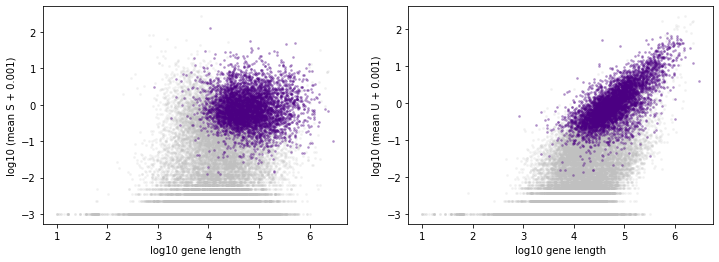

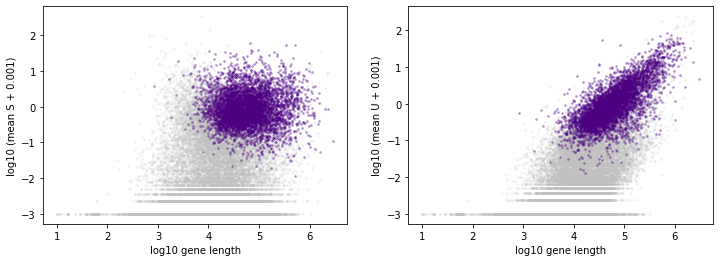

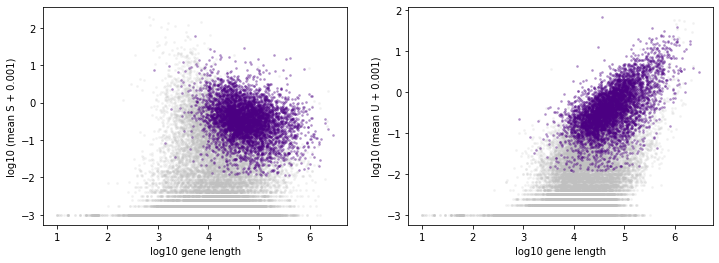

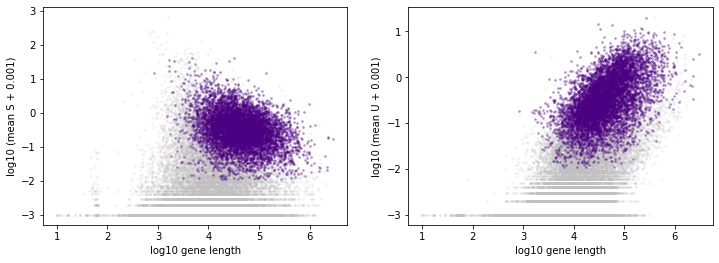

In [ ]:
dir_string,dataset_strings = construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='mouse',batch_id=1,\
                                             n_genes=200)

## Run inference

In this example, we will fit the bursty and constitutive models to all four datasets, using a Poisson sampling model on a $6\times 7$ grid.

allen_B01_gaba
Bursty
INFO:root:Global inference parameters stored to ./fits/gg_220530_022_mouse_1/allen_B01_gaba/Bursty_Poisson_6x7/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_B01_gaba
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_220530_022_mouse_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_220530_022_mouse_1/allen_B01_gaba/raw.sd.
INFO:root:Starting parallelized grid scan.


/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Runtime: 471.6 seconds.
Constitutive
INFO:root:Global inference parameters stored to ./fits/gg_220530_022_mouse_1/allen_B01_gaba/Constitutive_Poisson_6x7/parameters.pr.
INFO:root:Search data loaded from ./fits/gg_220530_022_mouse_1/allen_B01_gaba/raw.sd.
INFO:root:Starting parallelized grid scan.


/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Runtime: 142.6 seconds.
allen_C01_gaba
Bursty
INFO:root:Global inference parameters stored to ./fits/gg_220530_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_C01_gaba
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_220530_022_mouse_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_220530_022_mouse_1/allen_C01_gaba/raw.sd.
INFO:root:Starting parallelized grid scan.


/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Runtime: 448.6 seconds.
Constitutive
INFO:root:Global inference parameters stored to ./fits/gg_220530_022_mouse_1/allen_C01_gaba/Constitutive_Poisson_6x7/parameters.pr.
INFO:root:Search data loaded from ./fits/gg_220530_022_mouse_1/allen_C01_gaba/raw.sd.
INFO:root:Starting parallelized grid scan.


/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Runtime: 146.2 seconds.
neuron_1k_v3
Bursty
INFO:root:Global inference parameters stored to ./fits/gg_220530_022_mouse_1/neuron_1k_v3/Bursty_Poisson_6x7/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: neuron_1k_v3
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_220530_022_mouse_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_220530_022_mouse_1/neuron_1k_v3/raw.sd.
INFO:root:Starting parallelized grid scan.


/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Runtime: 531.3 seconds.
Constitutive
INFO:root:Global inference parameters stored to ./fits/gg_220530_022_mouse_1/neuron_1k_v3/Constitutive_Poisson_6x7/parameters.pr.
INFO:root:Search data loaded from ./fits/gg_220530_022_mouse_1/neuron_1k_v3/raw.sd.
INFO:root:Starting parallelized grid scan.


/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Runtime: 160.9 seconds.
heart_1k_v3
Bursty
INFO:root:Global inference parameters stored to ./fits/gg_220530_022_mouse_1/heart_1k_v3/Bursty_Poisson_6x7/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: heart_1k_v3
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./fits/gg_220530_022_mouse_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_220530_022_mouse_1/heart_1k_v3/raw.sd.
INFO:root:Starting parallelized grid scan.


/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Runtime: 758.8 seconds.
Constitutive
INFO:root:Global inference parameters stored to ./fits/gg_220530_022_mouse_1/heart_1k_v3/Constitutive_Poisson_6x7/parameters.pr.
INFO:root:Search data loaded from ./fits/gg_220530_022_mouse_1/heart_1k_v3/raw.sd.
INFO:root:Starting parallelized grid scan.


/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Runtime: 225.0 seconds.


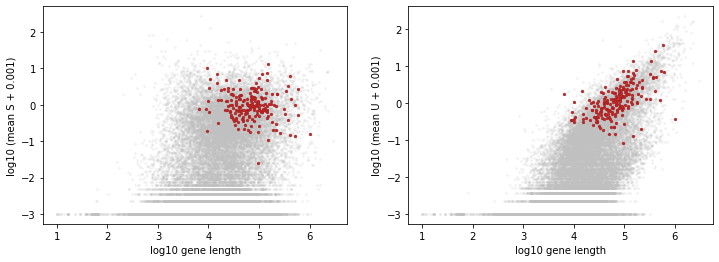

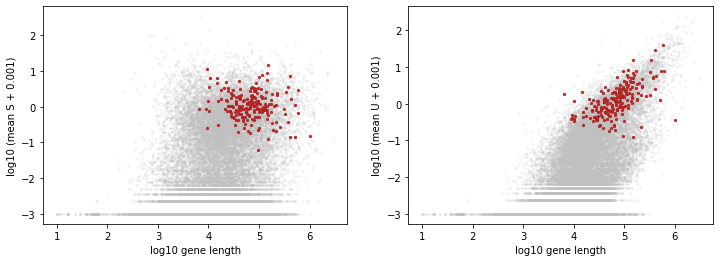

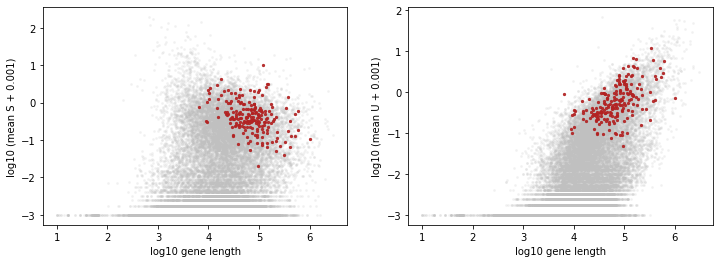

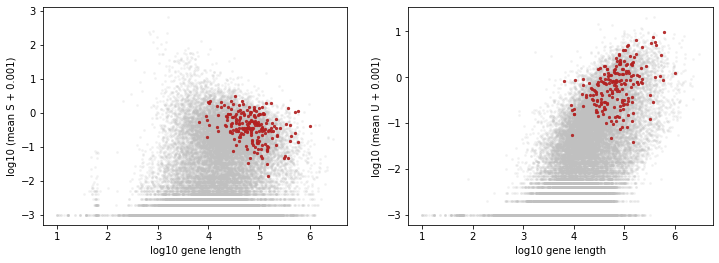

In [ ]:
models = ('Bursty','Constitutive')
n_datasets = len(dataset_names)
n_models = len(models)
lb = [[-1.0, -1.8, -1.8 ],
      [-1.0, -1.0 ]]
ub = [[4.2, 2.5, 3.5],
      [3.5, 3.5]]
grid = [6,7]

result_strings = []
for i in range(n_datasets):
    print(dataset_names[i])
    for j in range(n_models):
        fitmodel = CMEModel(models[j],'Poisson')
        print(models[j])
        inference_parameters = InferenceParameters(lb[j],ub[j],[-8, -3],[-5, 0],grid,\
                    dataset_strings[i],fitmodel,use_lengths = True,
                    gradient_params = {'max_iterations':10,'init_pattern':'moments','num_restarts':1})
        if j==0:
            search_data = extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                                dataset_strings[i], dir_string, dataset_attr_names=attribute_names)
        else:
            search_data = load_search_data(dataset_strings[i]+'/raw.sd')
        full_result_string = inference_parameters.fit_all_grid_points(2,search_data)
        result_strings.append(full_result_string)


In [ ]:
!tar -czvf sample_fits.tar.gz fits

fits/
fits/gg_220530_022_mouse_1/
fits/gg_220530_022_mouse_1/gene_set.csv
fits/gg_220530_022_mouse_1/heart_1k_v3/
fits/gg_220530_022_mouse_1/heart_1k_v3/raw.sd
fits/gg_220530_022_mouse_1/heart_1k_v3/diagnostic_figures/
fits/gg_220530_022_mouse_1/heart_1k_v3/diagnostic_figures/heart_1k_v3.png
fits/gg_220530_022_mouse_1/heart_1k_v3/Constitutive_Poisson_6x7/
fits/gg_220530_022_mouse_1/heart_1k_v3/Constitutive_Poisson_6x7/parameters.pr
fits/gg_220530_022_mouse_1/heart_1k_v3/Constitutive_Poisson_6x7/analysis_figures/
fits/gg_220530_022_mouse_1/heart_1k_v3/Constitutive_Poisson_6x7/grid_scan_results.res
fits/gg_220530_022_mouse_1/heart_1k_v3/Bursty_Poisson_6x7/
fits/gg_220530_022_mouse_1/heart_1k_v3/Bursty_Poisson_6x7/grid_scan_results_upd.res
fits/gg_220530_022_mouse_1/heart_1k_v3/Bursty_Poisson_6x7/parameters.pr
fits/gg_220530_022_mouse_1/heart_1k_v3/Bursty_Poisson_6x7/analysis_figures/
fits/gg_220530_022_mouse_1/heart_1k_v3/Bursty_Poisson_6x7/analysis_figures/length_dependence.png
fits/gg_

# Analysis

## Post-processing and QC

Load in search data.

In [ ]:
sd_arr = [load_search_data(x+'/raw.sd') for x in dataset_strings]

INFO:root:Search data loaded from ./fits/gg_220530_022_mouse_1/allen_B01_gaba/raw.sd.
INFO:root:Search data loaded from ./fits/gg_220530_022_mouse_1/allen_C01_gaba/raw.sd.
INFO:root:Search data loaded from ./fits/gg_220530_022_mouse_1/neuron_1k_v3/raw.sd.
INFO:root:Search data loaded from ./fits/gg_220530_022_mouse_1/heart_1k_v3/raw.sd.


In [ ]:
rs_burst = [result_strings[x] for x in (0,2,4,6)]
rs_const = [result_strings[x] for x in (1,3,5,7)]

Inspect all bursty result files and perform basic QC. We would like to be confident of the typical results:

*   The fits successfully recapitulate the joint count distributions
*   The sampling parameters appear to have a single unique optimum in $\{C_u, \lambda_s\}$
*   The physical parameters $\{b,\beta,\gamma\}$ are largely independent of gene length
*   The physical parameter distributions are consistent with a normal-inverse Gaussian law

In [ ]:
sr_arr = []
j=0

INFO:root:Grid scan results loaded from ./fits/gg_220530_022_mouse_1/allen_B01_gaba/Bursty_Poisson_6x7/grid_scan_results.res.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_220530_022_mouse_1/allen_B01_gaba/Bursty_Poisson_6x7/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_220530_022_mouse_1/allen_B01_gaba/Bursty_Poisson_6x7/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 7 genes out of 200. Runtime: 0.2 seconds.


/usr/local/lib/python3.7/dist-packages/monod/inference.py:582: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if gene_filter.dtype != np.bool:


INFO:root:Figure stored to ./fits/gg_220530_022_mouse_1/allen_B01_gaba/Bursty_Poisson_6x7/analysis_figures/subsampling.png.
INFO:root:Figure stored to ./fits/gg_220530_022_mouse_1/allen_B01_gaba/Bursty_Poisson_6x7/analysis_figures/subsampling_stability.png.
INFO:root:Original optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 7 genes out of 200. Runtime: 0.2 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 7 genes out of 200. Runtime: 0.2 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 7 genes out of 200. Runtime: 0.2 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 7 genes out of 200. Runtime: 0.2 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 7 genes out of 200. Runtime: 0.2 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Re

/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:3857: RuntimeWarning: overflow encountered in exp
  fac1 = a / np.pi * np.exp(gamma)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:3857: RuntimeWarning: overflow encountered in double_scalars
  fac1 = a / np.pi * np.exp(gamma)


INFO:root:Figure stored to ./fits/gg_220530_022_mouse_1/allen_B01_gaba/Bursty_Poisson_6x7/analysis_figures/parameter_marginals.png.


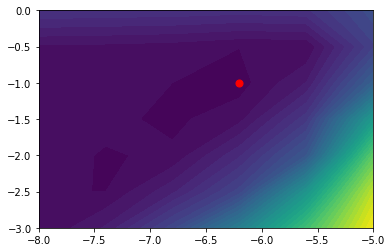

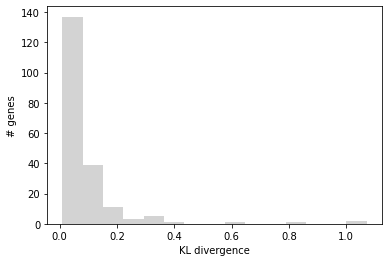

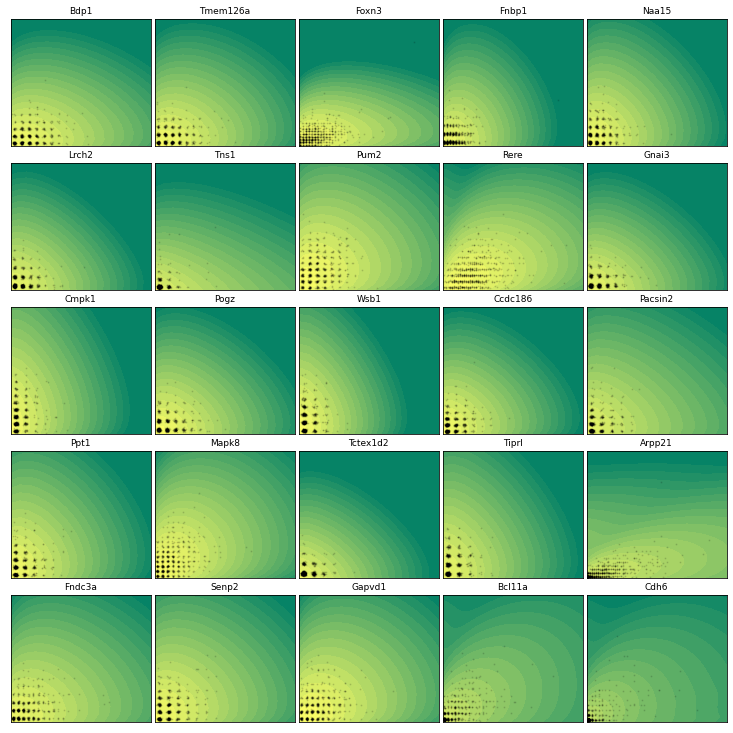

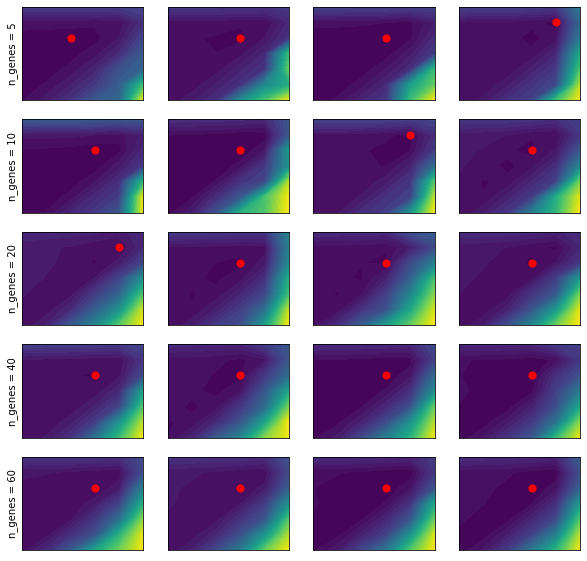

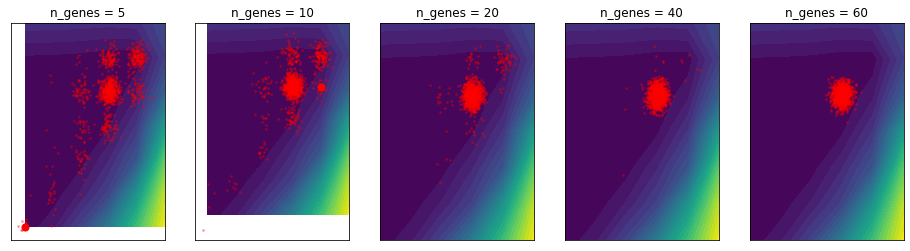

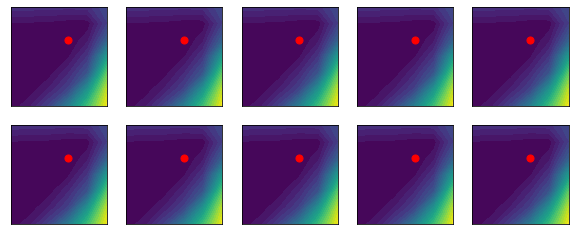

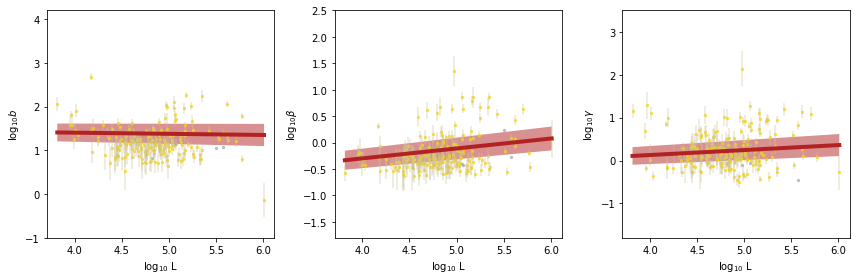

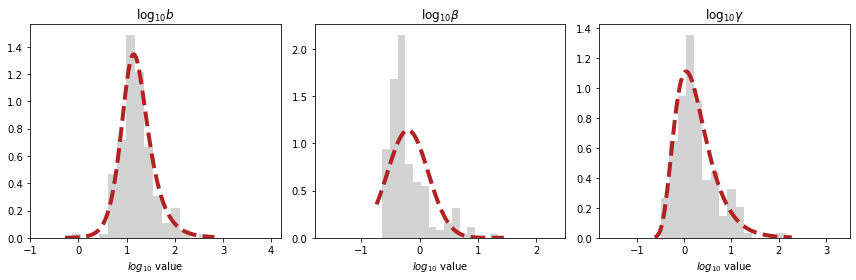

In [ ]:
sr = load_search_results(rs_burst[j])
sd = sd_arr[j]
fig1,ax1 = plt.subplots(1,1)
sr.find_sampling_optimum()
sr.plot_landscape(ax1)



fig1,ax1 = plt.subplots(1,1)
sr.plot_KL(ax1)

sr.plot_gene_distributions(sd,marg='joint')

_=sr.chisquare_testing(sd)
sr.resample_opt_viz()
sr.resample_opt_mc_viz()
sr.chisq_best_param_correction(sd,viz=True) 

sr.compute_sigma(sd,num_cores=2)
sr.plot_param_L_dep(plot_errorbars=True,plot_fit=True)
sr.plot_param_marg()
sr.update_on_disk()
sr_arr.append(sr)

j+=1


INFO:root:Grid scan results loaded from ./fits/gg_220530_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/grid_scan_results.res.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_220530_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_220530_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 3 genes out of 200. Runtime: 0.2 seconds.


/usr/local/lib/python3.7/dist-packages/monod/inference.py:582: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if gene_filter.dtype != np.bool:


INFO:root:Figure stored to ./fits/gg_220530_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/subsampling.png.
INFO:root:Figure stored to ./fits/gg_220530_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/analysis_figures/subsampling_stability.png.
INFO:root:Original optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 3 genes out of 200. Runtime: 0.2 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 3 genes out of 200. Runtime: 0.2 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 3 genes out of 200. Runtime: 0.2 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 3 genes out of 200. Runtime: 0.2 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 3 genes out of 200. Runtime: 0.2 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Re

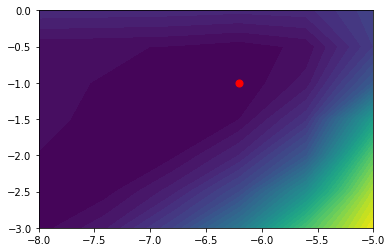

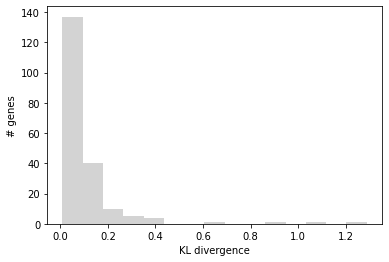

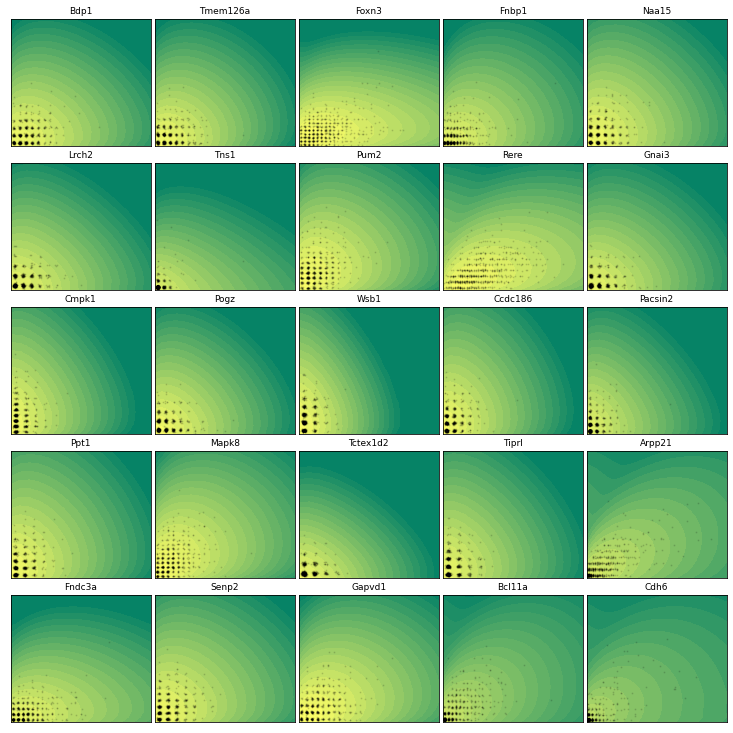

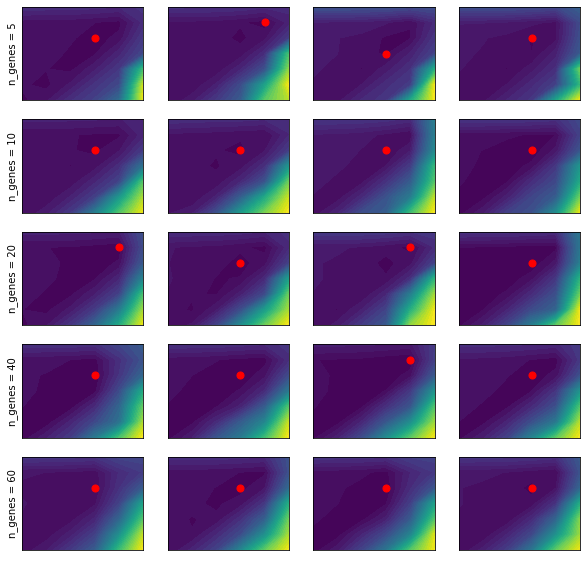

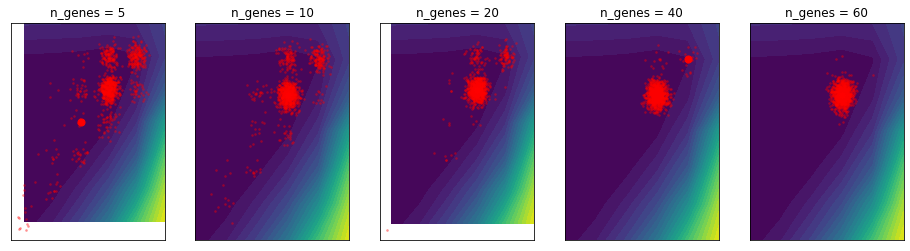

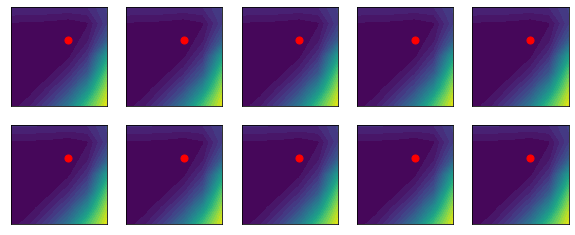

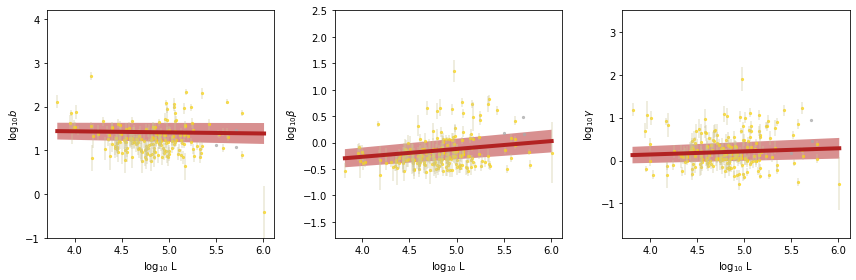

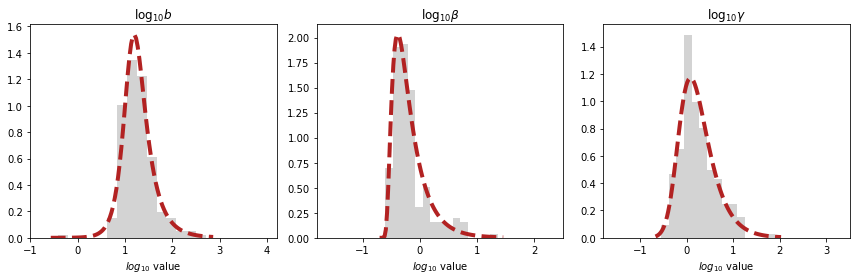

In [ ]:
sr = load_search_results(rs_burst[j])
sd = sd_arr[j]
fig1,ax1 = plt.subplots(1,1)
sr.find_sampling_optimum()
sr.plot_landscape(ax1)



fig1,ax1 = plt.subplots(1,1)
sr.plot_KL(ax1)

sr.plot_gene_distributions(sd,marg='joint')

_=sr.chisquare_testing(sd)
sr.resample_opt_viz()
sr.resample_opt_mc_viz()
sr.chisq_best_param_correction(sd,viz=True) 

sr.compute_sigma(sd,num_cores=2)
sr.plot_param_L_dep(plot_errorbars=True,plot_fit=True)
sr.plot_param_marg()
sr.update_on_disk()
sr_arr.append(sr)

j+=1


INFO:root:Grid scan results loaded from ./fits/gg_220530_022_mouse_1/neuron_1k_v3/Bursty_Poisson_6x7/grid_scan_results.res.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_220530_022_mouse_1/neuron_1k_v3/Bursty_Poisson_6x7/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_220530_022_mouse_1/neuron_1k_v3/Bursty_Poisson_6x7/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 25 genes out of 200. Runtime: 0.2 seconds.


/usr/local/lib/python3.7/dist-packages/monod/inference.py:582: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if gene_filter.dtype != np.bool:


INFO:root:Figure stored to ./fits/gg_220530_022_mouse_1/neuron_1k_v3/Bursty_Poisson_6x7/analysis_figures/subsampling.png.
INFO:root:Figure stored to ./fits/gg_220530_022_mouse_1/neuron_1k_v3/Bursty_Poisson_6x7/analysis_figures/subsampling_stability.png.
INFO:root:Original optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 25 genes out of 200. Runtime: 0.2 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 25 genes out of 200. Runtime: 0.2 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 25 genes out of 200. Runtime: 0.2 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 25 genes out of 200. Runtime: 0.2 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. Rejected 25 genes out of 200. Runtime: 0.2 seconds.
INFO:root:New optimum: -6.20, -1.00.
INFO:root:Chi-square computation complete. R

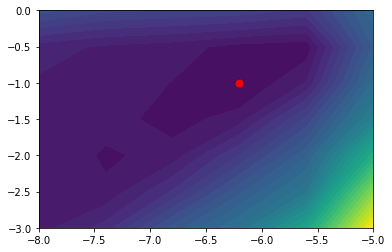

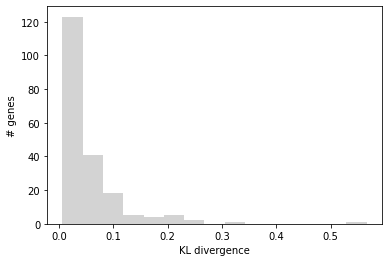

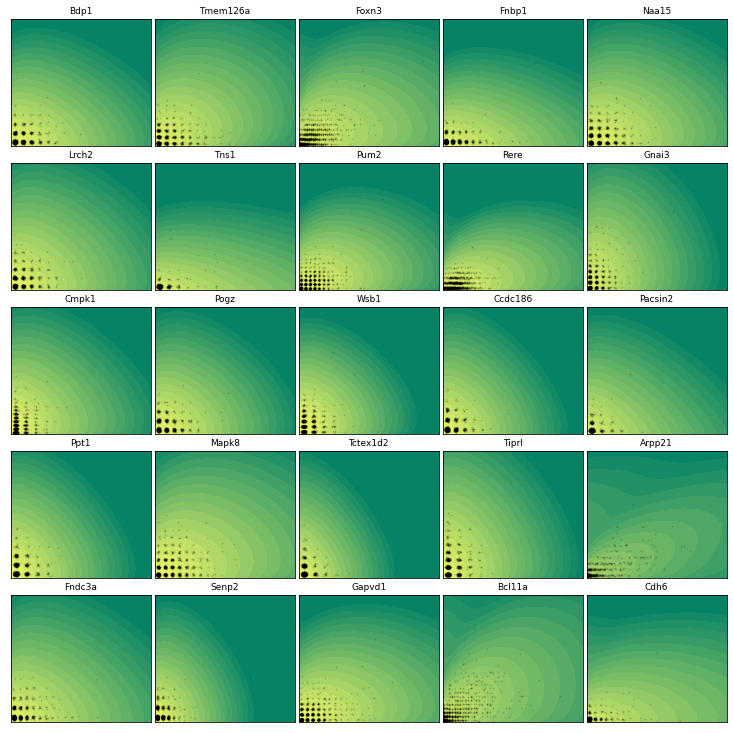

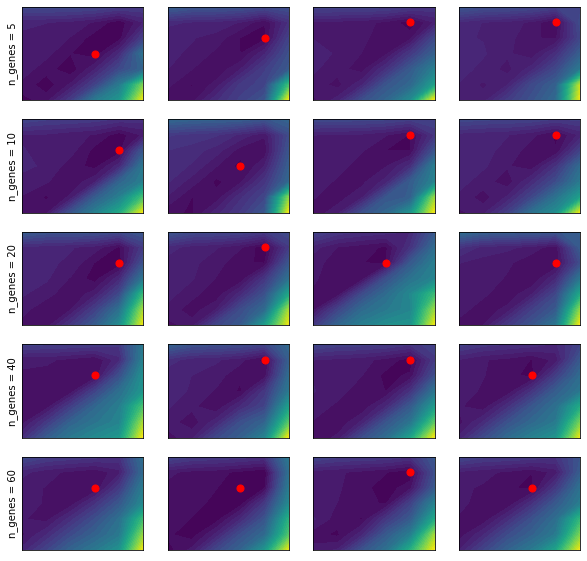

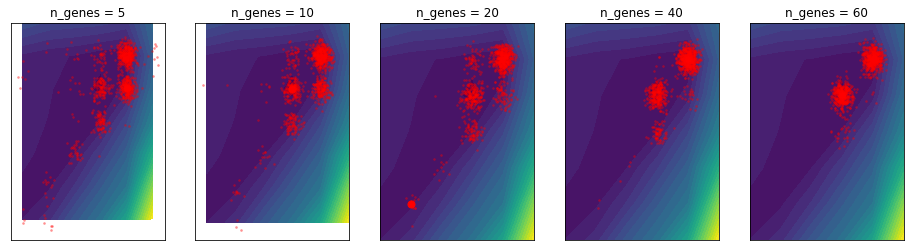

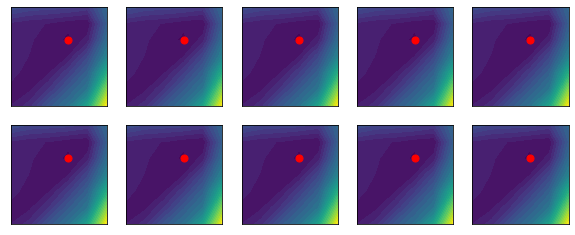

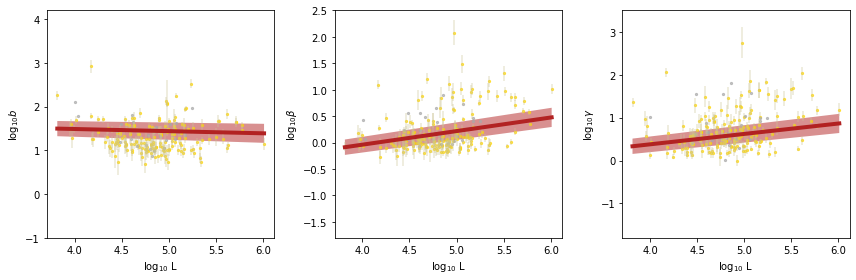

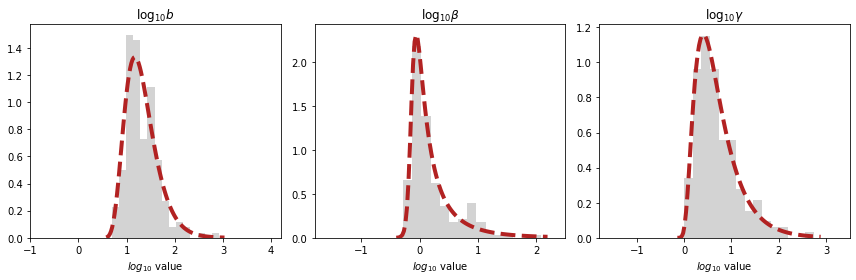

In [ ]:
sr = load_search_results(rs_burst[j])
sd = sd_arr[j]
fig1,ax1 = plt.subplots(1,1)
sr.find_sampling_optimum()
sr.plot_landscape(ax1)



fig1,ax1 = plt.subplots(1,1)
sr.plot_KL(ax1)

sr.plot_gene_distributions(sd,marg='joint')

_=sr.chisquare_testing(sd)
sr.resample_opt_viz()
sr.resample_opt_mc_viz()
sr.chisq_best_param_correction(sd,viz=True) 

sr.compute_sigma(sd,num_cores=2)
sr.plot_param_L_dep(plot_errorbars=True,plot_fit=True)
sr.plot_param_marg()
sr.update_on_disk()
sr_arr.append(sr)

j+=1


INFO:root:Grid scan results loaded from ./fits/gg_220530_022_mouse_1/heart_1k_v3/Bursty_Poisson_6x7/grid_scan_results.res.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_220530_022_mouse_1/heart_1k_v3/Bursty_Poisson_6x7/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_220530_022_mouse_1/heart_1k_v3/Bursty_Poisson_6x7/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 20 genes out of 200. Runtime: 0.3 seconds.


/usr/local/lib/python3.7/dist-packages/monod/inference.py:582: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if gene_filter.dtype != np.bool:


INFO:root:Figure stored to ./fits/gg_220530_022_mouse_1/heart_1k_v3/Bursty_Poisson_6x7/analysis_figures/subsampling.png.
INFO:root:Figure stored to ./fits/gg_220530_022_mouse_1/heart_1k_v3/Bursty_Poisson_6x7/analysis_figures/subsampling_stability.png.
INFO:root:Original optimum: -5.60, -0.50.
INFO:root:Chi-square computation complete. Rejected 20 genes out of 200. Runtime: 0.3 seconds.
INFO:root:New optimum: -5.60, -0.50.
INFO:root:Chi-square computation complete. Rejected 20 genes out of 200. Runtime: 0.3 seconds.
INFO:root:New optimum: -5.60, -0.50.
INFO:root:Chi-square computation complete. Rejected 20 genes out of 200. Runtime: 0.3 seconds.
INFO:root:New optimum: -5.60, -0.50.
INFO:root:Chi-square computation complete. Rejected 20 genes out of 200. Runtime: 0.3 seconds.
INFO:root:New optimum: -5.60, -0.50.
INFO:root:Chi-square computation complete. Rejected 20 genes out of 200. Runtime: 0.3 seconds.
INFO:root:New optimum: -5.60, -0.50.
INFO:root:Chi-square computation complete. Rej

/usr/local/lib/python3.7/dist-packages/monod/inference.py:769: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index,:] = np.sqrt(np.diag(hess_inv))/np.sqrt(self.n_cells)


INFO:root:Figure stored to ./fits/gg_220530_022_mouse_1/heart_1k_v3/Bursty_Poisson_6x7/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_220530_022_mouse_1/heart_1k_v3/Bursty_Poisson_6x7/analysis_figures/parameter_marginals.png.


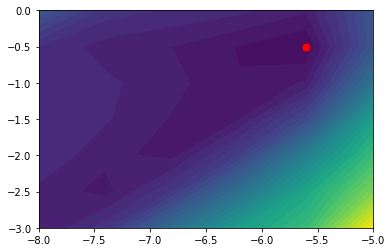

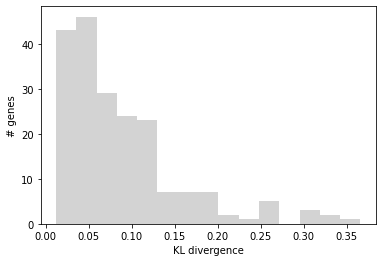

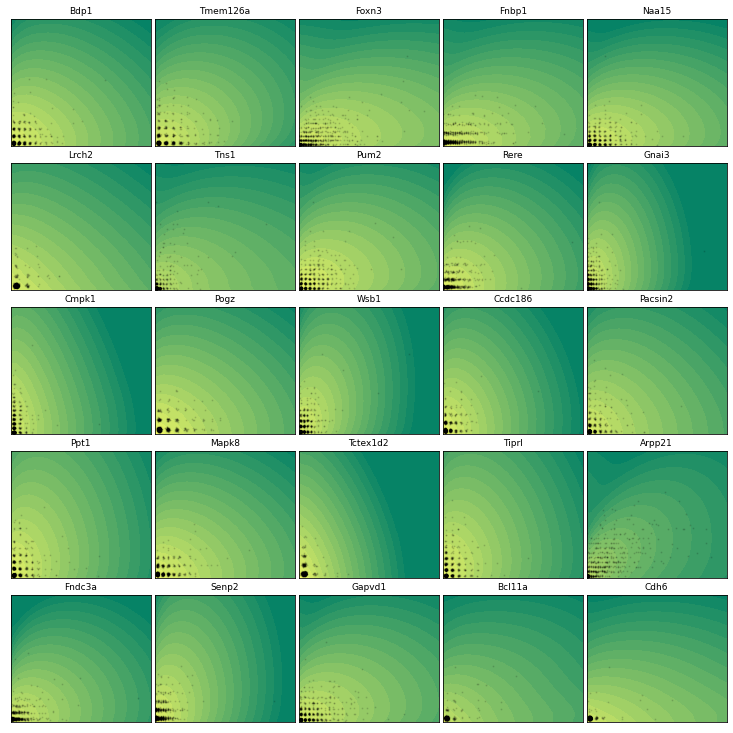

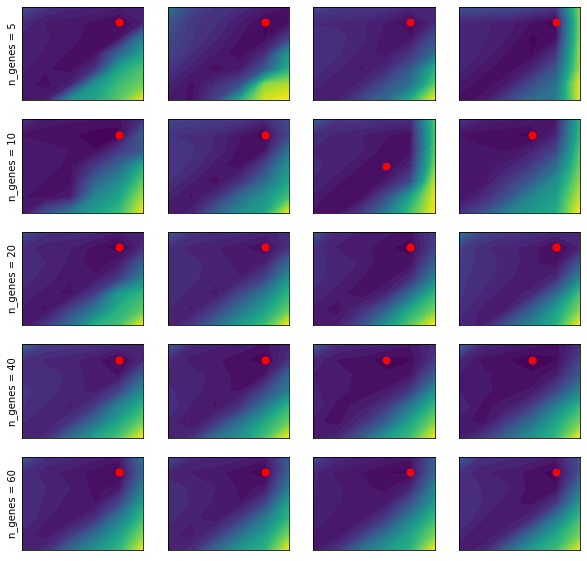

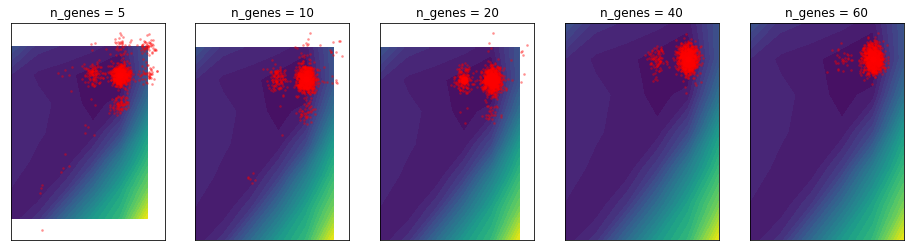

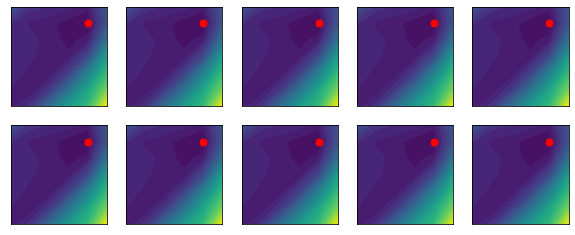

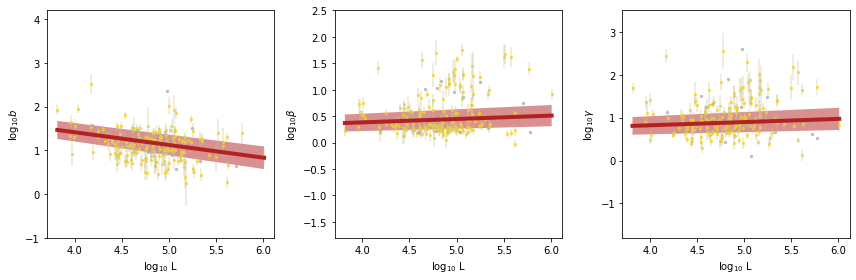

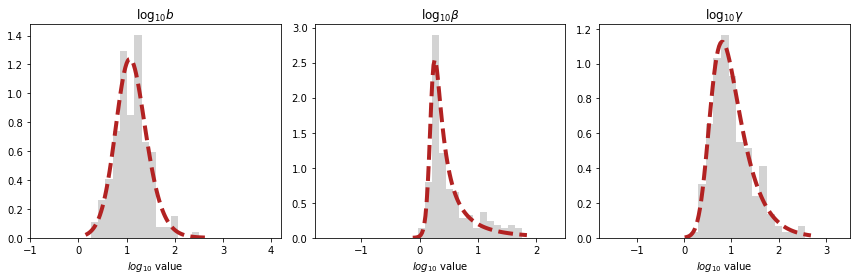

In [ ]:
sr = load_search_results(rs_burst[j])
sd = sd_arr[j]
fig1,ax1 = plt.subplots(1,1)
sr.find_sampling_optimum()
sr.plot_landscape(ax1)



fig1,ax1 = plt.subplots(1,1)
sr.plot_KL(ax1)

sr.plot_gene_distributions(sd,marg='joint')

_=sr.chisquare_testing(sd)
sr.resample_opt_viz()
sr.resample_opt_mc_viz()
sr.chisq_best_param_correction(sd,viz=True) 

sr.compute_sigma(sd,num_cores=2)
sr.plot_param_L_dep(plot_errorbars=True,plot_fit=True)
sr.plot_param_marg()
sr.update_on_disk()
sr_arr.append(sr)


In [ ]:
!tar -czvf sample_fits.tar.gz fits

fits/
fits/gg_220530_022_mouse_1/
fits/gg_220530_022_mouse_1/gene_set.csv
fits/gg_220530_022_mouse_1/heart_1k_v3/
fits/gg_220530_022_mouse_1/heart_1k_v3/raw.sd
fits/gg_220530_022_mouse_1/heart_1k_v3/diagnostic_figures/
fits/gg_220530_022_mouse_1/heart_1k_v3/diagnostic_figures/heart_1k_v3.png
fits/gg_220530_022_mouse_1/heart_1k_v3/Constitutive_Poisson_6x7/
fits/gg_220530_022_mouse_1/heart_1k_v3/Constitutive_Poisson_6x7/parameters.pr
fits/gg_220530_022_mouse_1/heart_1k_v3/Constitutive_Poisson_6x7/analysis_figures/
fits/gg_220530_022_mouse_1/heart_1k_v3/Constitutive_Poisson_6x7/grid_scan_results.res
fits/gg_220530_022_mouse_1/heart_1k_v3/Bursty_Poisson_6x7/
fits/gg_220530_022_mouse_1/heart_1k_v3/Bursty_Poisson_6x7/grid_scan_results_upd.res
fits/gg_220530_022_mouse_1/heart_1k_v3/Bursty_Poisson_6x7/parameters.pr
fits/gg_220530_022_mouse_1/heart_1k_v3/Bursty_Poisson_6x7/analysis_figures/
fits/gg_220530_022_mouse_1/heart_1k_v3/Bursty_Poisson_6x7/analysis_figures/length_dependence.png
fits/gg_

# Model identification

With the fits computed, we can investigate whether the results are more consistent with the bursty or the constitutive model. To do this, we compute and plot the distribution of Akaike Information Criterion weights.

INFO:root:Grid scan results loaded from ./fits/gg_220530_022_mouse_1/allen_B01_gaba/Bursty_Poisson_6x7/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_220530_022_mouse_1/allen_B01_gaba/Constitutive_Poisson_6x7/grid_scan_results.res.
INFO:root:Figure stored to ./fits/gg_220530_022_mouse_1/analysis_figures/AIC_comparison_allen_B01_gaba_burst_const.png.
INFO:root:Grid scan results loaded from ./fits/gg_220530_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_220530_022_mouse_1/allen_C01_gaba/Constitutive_Poisson_6x7/grid_scan_results.res.
INFO:root:Figure stored to ./fits/gg_220530_022_mouse_1/analysis_figures/AIC_comparison_allen_C01_gaba_burst_const.png.
INFO:root:Grid scan results loaded from ./fits/gg_220530_022_mouse_1/neuron_1k_v3/Bursty_Poisson_6x7/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_220530_022_mouse_1/neuron_1k_v3/Constitutive_Poisson_6x7/grid_scan_res

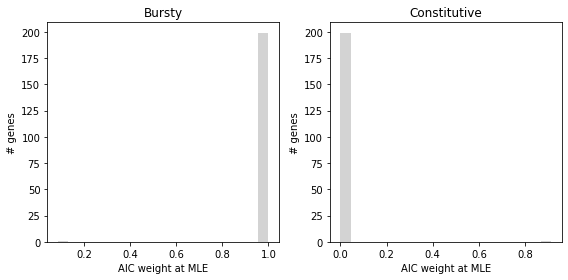

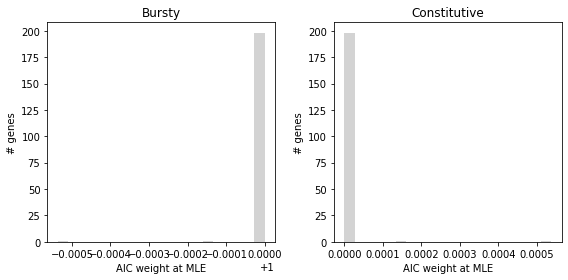

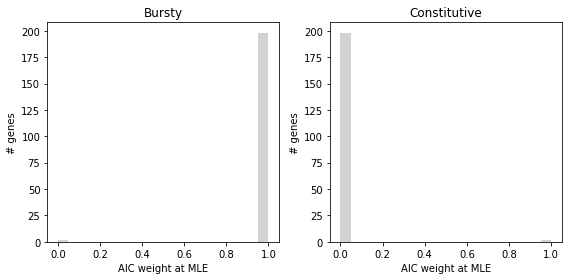

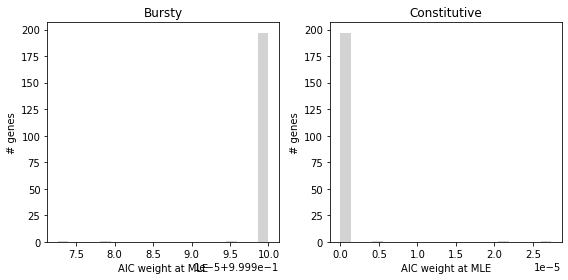

In [ ]:
w = []

for j in range(n_datasets):
    sd = sd_arr[j]
    
    sr_burst = load_search_results(rs_burst[j])
    sr_burst.find_sampling_optimum()
    
    sr_const = load_search_results(rs_const[j])
    sr_const.find_sampling_optimum()
    
    make_batch_analysis_dir([sr_burst,sr_const],dir_string)

    w_ = plot_AIC_weights([sr_burst,sr_const],sd,models,meta=dataset_names[j]+'_burst_const',savefig=True)
    w.append(w_)


In [ ]:
w = np.asarray(w)

In [ ]:
w.mean(2)

array([[9.95430720e-01, 4.56928027e-03],
       [9.99996501e-01, 3.49863380e-06],
       [9.89991604e-01, 1.00083965e-02],
       [9.99999725e-01, 2.75066345e-07]])

In [ ]:
w.mean(2).min(0)

array([9.89991604e-01, 2.75066345e-07])

In [ ]:
w.mean(2).max(0)

array([0.99999972, 0.0100084 ])

In [ ]:
(w[:,1,:]>0.5).sum(1)

array([1, 0, 2, 0])

The constitutive model is only judged likely ($w_j>0.5$) for at most a single gene per dataset. This suggests it is insufficiently powerful to describe sequencing data, and overdispersed models are mandatory.

# Variance decomposition

With the fits in hand, we can consider the distributions' variance decompositions and compare them to the change in $\text{CV}^2$ induced by normalization and log-transformation. First, we select the post-processed bursty fits.

In [ ]:
rs_burst = [x[:-4 ]+'_upd.res' for x in rs_burst]

In [ ]:
sr_arr = []

for j in range(n_datasets):
    sr = load_search_results(rs_burst[j])
    sr_arr.append(sr)

INFO:root:Grid scan results loaded from ./fits/gg_220530_022_mouse_1/allen_B01_gaba/Bursty_Poisson_6x7/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220530_022_mouse_1/allen_C01_gaba/Bursty_Poisson_6x7/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220530_022_mouse_1/neuron_1k_v3/Bursty_Poisson_6x7/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220530_022_mouse_1/heart_1k_v3/Bursty_Poisson_6x7/grid_scan_results_upd.res.


Now, we obtain the discarded part of $\text{CV}^2$ upon the non-parametric processing, as well as the extrinsic noise portion of the analytical noise decomposition at the maximum likelihood estimate. 

In [ ]:
f_tech_naive = []
f_ext_mech = []

for j in range(n_datasets):
    f_tech_naive.append(sd_arr[j].get_noise_decomp()[:,1,1])
    sr_arr[j].find_sampling_optimum()
    d = sr_arr[j].get_noise_decomp()
    f_ext_mech.append(d[:,1,1]) #bursting noise
    
f_tech_naive = np.asarray(f_tech_naive)
f_ext_mech = np.asarray(f_ext_mech)


/usr/local/lib/python3.7/dist-packages/monod/extract_data.py:221: RuntimeWarning: invalid value encountered in true_divide
  U_ = self.U/(self.U.sum(0)[None,:])*C


Oddly, applying the "cell size" normalization and log-transformation to the the neuron and heart datasets substantially *increases* relative variance.

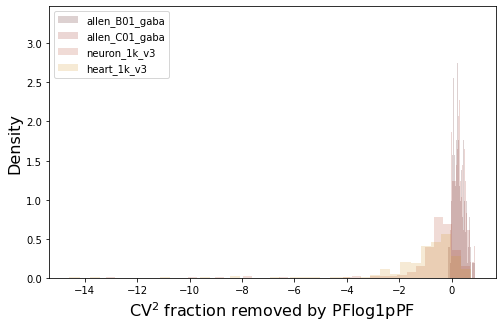

In [ ]:
plt.figure(figsize=(8,5))
for j in range(n_datasets):
    plt.hist(f_tech_naive[j],nbin,alpha=0.2,density=True,facecolor=Demuth[j%len(Demuth)],label=dataset_names[j])
plt.xlabel(r'CV$^2$ fraction removed by PFlog1pPF',fontsize=fs)
plt.ylabel('Density',fontsize=fs)
plt.legend()

On the other hand, the fraction of noise attributable to extrinsic variation in transcription rate, under the bursty model, has a fairly consistent distribution across the four datasets.

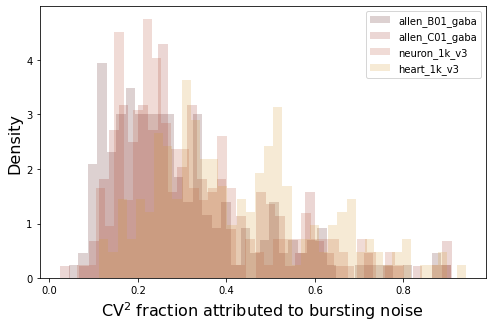

In [ ]:
plt.figure(figsize=(8,5))
for j in range(n_datasets):
    plt.hist(f_ext_mech[j],nbin,alpha=0.2,density=True,facecolor=Demuth[j%len(Demuth)],label=dataset_names[j])
plt.xlabel(r'CV$^2$ fraction attributed to bursting noise',fontsize=fs)
plt.ylabel('Density',fontsize=fs)
plt.legend()

The biological noise fraction appears to vary with the noise fraction removed by PFlog1pPF for the two cell type-specific datasets. However, the perponderance of genes with increased variance in the two other datasets obscures the trend, possibly because the assumptions of the transformation are violated. 

INFO:root:Figure stored to ./fits/gg_220530_022_mouse_1/analysis_figures/CV2_noise.png.


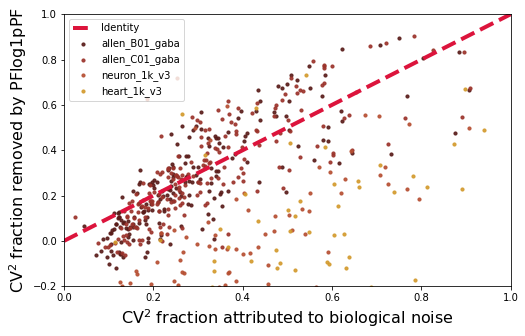

In [ ]:
plt.figure(figsize=(8,5))
for j in range(n_datasets):
    plt.scatter(f_ext_mech[j],f_tech_naive[j],s=10,alpha=0.9,c=Demuth[j%len(Demuth)],label=dataset_names[j])
plt.plot([0,1],[0,1],'--',c='crimson',linewidth=4,label='Identity')
plt.xlabel(r'CV$^2$ fraction attributed to biological noise',fontsize=fs)
plt.ylabel(r'CV$^2$ fraction removed by PFlog1pPF',fontsize=fs)

plt.legend()

analysis_dir_string = dir_string+'/analysis_figures'
fig_string = analysis_dir_string+'/CV2_noise.png'
plt.xlim([0,1])
plt.ylim([-0.2,1])
plt.savefig(fig_string,dpi=450)
log.info('Figure stored to {}.'.format(fig_string))


INFO:root:Figure stored to ./fits/gg_220530_022_mouse_1/analysis_figures/CV2_noise_full.png.


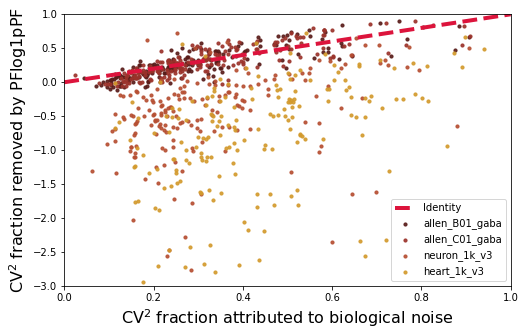

In [ ]:
plt.figure(figsize=(8,5))
for j in range(n_datasets):
    plt.scatter(f_ext_mech[j],f_tech_naive[j],s=10,alpha=0.9,c=Demuth[j%len(Demuth)],label=dataset_names[j])
plt.plot([0,1],[0,1],'--',c='crimson',linewidth=4,label='Identity')
plt.xlabel(r'CV$^2$ fraction attributed to biological noise',fontsize=fs)
plt.ylabel(r'CV$^2$ fraction removed by PFlog1pPF',fontsize=fs)

plt.legend()

analysis_dir_string = dir_string+'/analysis_figures'
fig_string = analysis_dir_string+'/CV2_noise_full.png'
plt.xlim([0,1])
plt.ylim([-3,1])
plt.savefig(fig_string,dpi=450)
log.info('Figure stored to {}.'.format(fig_string))


# Differential regulation analysis

Finally, we can analyze the four mouse datasets in terms of differences between their mRNA copy number distribution, potentially suggest differential regulation of their transcriptional processes.

In [ ]:
make_batch_analysis_dir(sr_arr,dir_string)

In [ ]:
dataset_names

['allen_B01_gaba', 'allen_C01_gaba', 'neuron_1k_v3', 'heart_1k_v3']

In [ ]:
pairs = [[0,1],[0,2],[2,3]]

INFO:root:Figure stored to ./fits/gg_220530_022_mouse_1/analysis_figures/pair_parameter_comparison_pair_1.png.
INFO:root:Figure stored to ./fits/gg_220530_022_mouse_1/analysis_figures/pair_parameter_comparison_pair_2.png.
INFO:root:Figure stored to ./fits/gg_220530_022_mouse_1/analysis_figures/pair_parameter_comparison_pair_3.png.


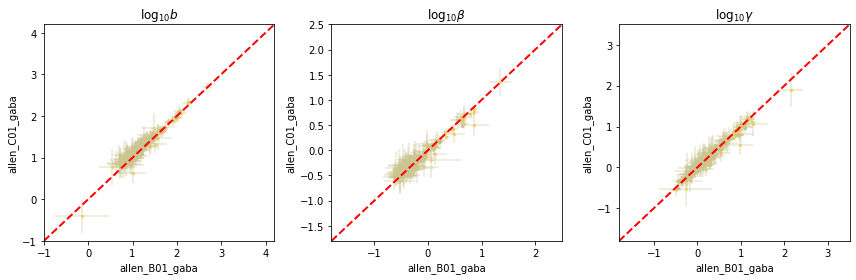

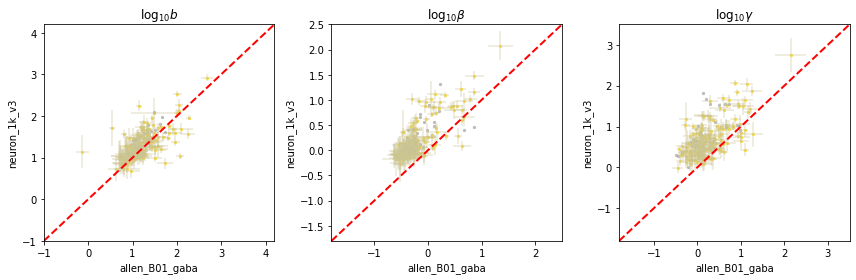

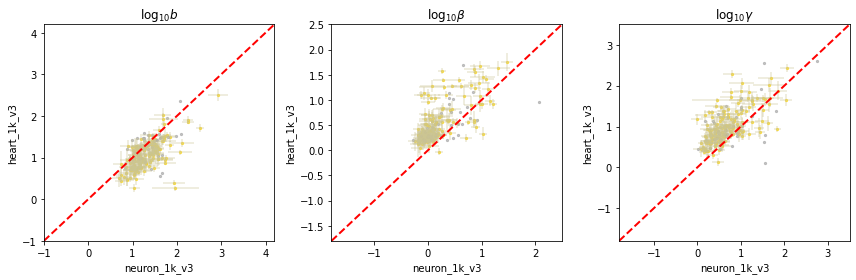

In [ ]:
for i in range(len(pairs)):
    i1 = pairs[i][0]
    i2 = pairs[i][1]
    plot_params_for_pair(sr_arr[i1],sr_arr[i2],\
                         distinguish_rej=True,plot_errorbars=True,meta = 'pair_'+str(i+1),xlabel = dataset_names[i1],\
                         ylabel = dataset_names[i2])


INFO:root:Figure stored to ./fits/gg_220530_022_mouse_1/analysis_figures/mean_comparison_s.png.


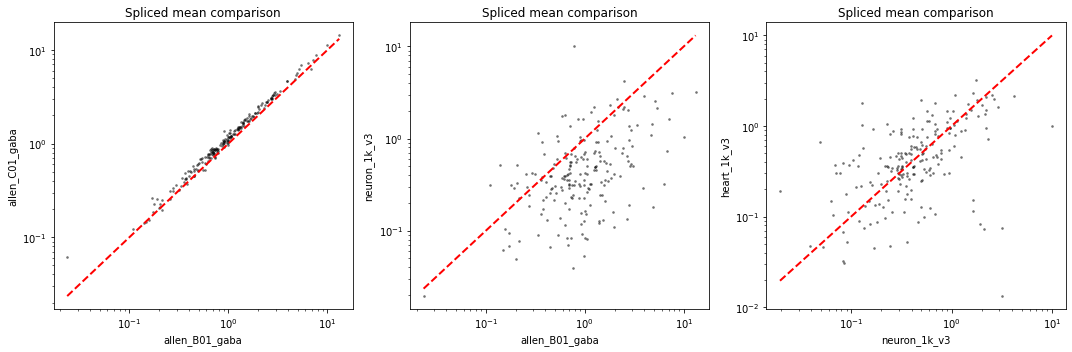

In [ ]:
fig1,ax1= plt.subplots(1,len(pairs),figsize=(15,5))
for i in range(len(pairs)):
    i1 = pairs[i][0]
    i2 = pairs[i][1]
    m1 = [sd_arr[i1].moments[x]['S_mean']  for x in range(sd_arr[i1].n_genes)]
    m2 = [sd_arr[i2].moments[x]['S_mean'] for x in range(sd_arr[i2].n_genes)]
    ax1[i].scatter(m1,m2,3,'k',alpha=0.4)
    ax1[i].set_xscale('log')
    ax1[i].set_yscale('log')
    ax1[i].set_xlabel(dataset_names[i1])
    ax1[i].set_ylabel(dataset_names[i2])
    ax1[i].set_title('Spliced mean comparison')
    xl = [min(m1),max(m1)]
    ax1[i].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()
fig_string = sr_arr[0].batch_analysis_string+'/mean_comparison_s.png'
plt.savefig(fig_string)
log.info('Figure stored to {}.'.format(fig_string))


INFO:root:Figure stored to ./fits/gg_220530_022_mouse_1/analysis_figures/parameter_residuals_pair_1.png.


/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


INFO:root:Figure stored to ./fits/gg_220530_022_mouse_1/analysis_figures/parameter_residuals_pair_2.png.
INFO:root:Figure stored to ./fits/gg_220530_022_mouse_1/analysis_figures/parameter_residuals_pair_3.png.


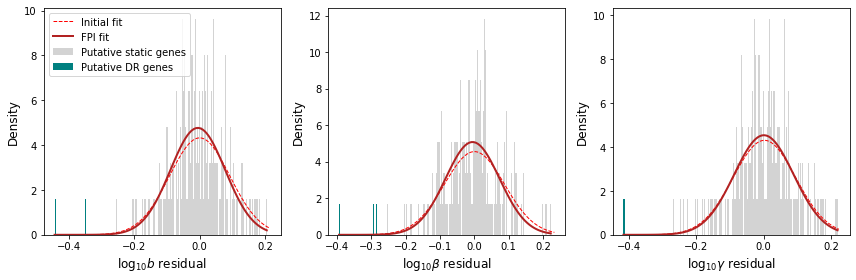

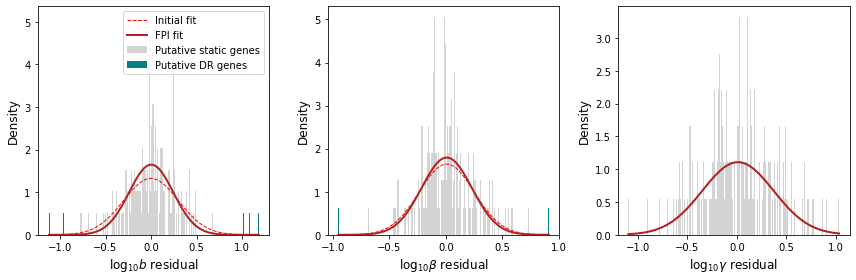

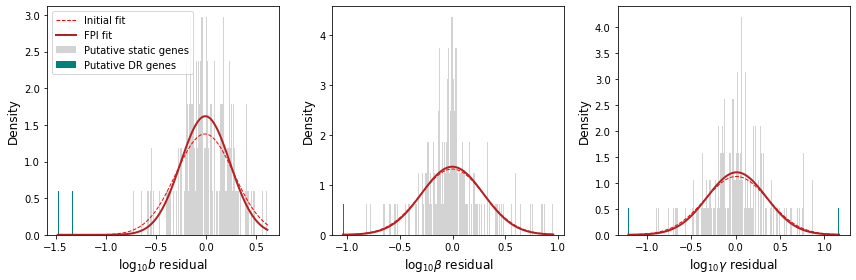

In [ ]:
dr_analysis = []
for i in range(len(pairs)):
    i1 = pairs[i][0]
    i2 = pairs[i][1]
    dr_analysis.append(compute_diffreg(sr_arr[i1],sr_arr[i2],viz=True,modeltype='id',meta= 'pair_'+str(i+1),use_sigma=True))


In [ ]:
dr_params = np.asarray([x[1] for x in dr_analysis])

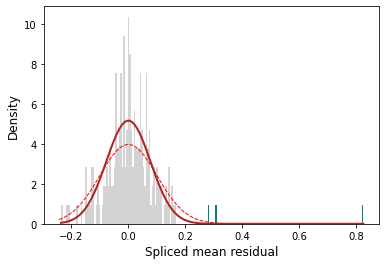

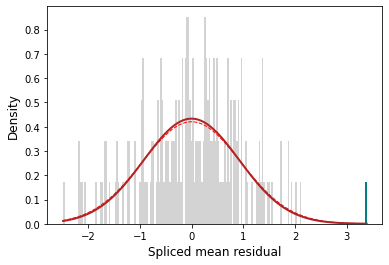

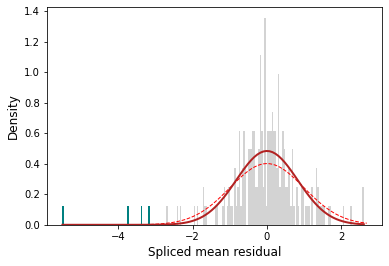

In [ ]:
de_ttest = []
de_logmeanfpi = []
for i in range(len(pairs)):
    i1 = pairs[i][0]
    i2 = pairs[i][1]
    de_ttest.append(compute_diffexp(sd_arr[i1],sd_arr[i2],logscale=True,viz=False,method='ttest'))
    de_logmeanfpi.append(compute_diffexp(sd_arr[i1],sd_arr[i2],method='logmeanfpi',modeltype='id',viz=True))
de_ttest=np.asarray(de_ttest)
de_logmeanfpi=np.asarray(de_logmeanfpi)


In [ ]:
de_ttest.shape

(3, 200)

In [ ]:
dr_params.shape

(3, 3, 200)

In [ ]:
gf = dr_params.any(1)

In [ ]:
(gf & ~de_ttest).sum(1)

array([3, 1, 0])

In [ ]:
gf.sum(1)

array([3, 6, 5])

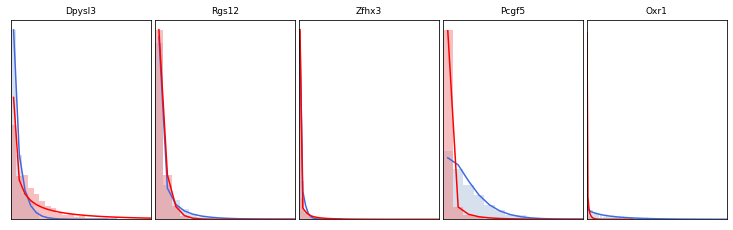

In [ ]:
i=1
i1 = pairs[i][0]
i2 = pairs[i][1]
compare_gene_distributions([sr_arr[i1],sr_arr[i2]], [sd_arr[i1],sd_arr[i2]],
                          genes_to_plot=gf[i],marg='nascent',logscale=False,sz=(1,5),figsize=(10,3))

In [ ]:
(gf & ~de_ttest).sum(1)

array([3, 1, 0])

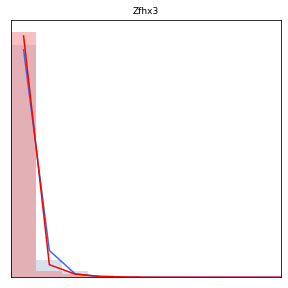

In [ ]:
compare_gene_distributions([sr_arr[i1],sr_arr[i2]], [sd_arr[i1],sd_arr[i2]],
                          genes_to_plot=(gf & ~de_ttest)[i],marg='mature',logscale=False,sz=(1,2),figsize=(8,4))
plt.gcf().delaxes(plt.gca())

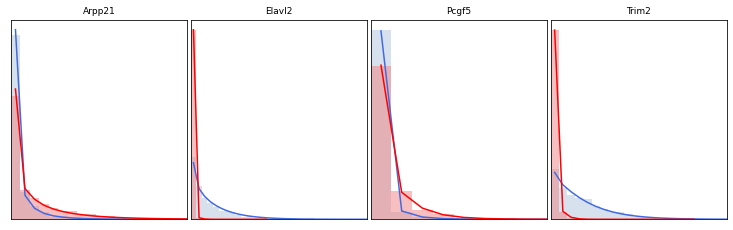

In [ ]:
i=2
i1 = pairs[i][0]
i2 = pairs[i][1]
compare_gene_distributions([sr_arr[i1],sr_arr[i2]], [sd_arr[i1],sd_arr[i2]],
                          genes_to_plot=gf[i],marg='mature',logscale=False,sz=(1,4),figsize=(10,3))

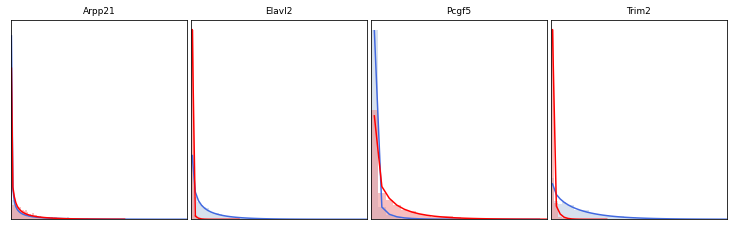

In [ ]:
i=2
i1 = pairs[i][0]
i2 = pairs[i][1]
compare_gene_distributions([sr_arr[i1],sr_arr[i2]], [sd_arr[i1],sd_arr[i2]],
                          genes_to_plot=gf[i],marg='nascent',logscale=False,sz=(1,4),figsize=(10,3))

In [ ]:
t2 = time.time()
print('Runtime: {:.0f} seconds.'.format(t2-t1))

Runtime: 3348 seconds.
